In [1]:
from google.colab import drive

drive.mount('/content/drive')
FOLDERNAME = "Stanford Summer Session/SOC 128D"

#Packages for working with data
import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sb
import plotnine as pn
import numpy as np

mplt.style.use("ggplot")

Mounted at /content/drive


1. Choose a topic related to climate change. Use the RedditextractoR package to get the thread content of posts related to this topic. Put your data in tidytext format, and show the first 6 rows of the threads and comments, separately.

In [2]:
# I could not get RedditextractoR to work properly and consistently, thus I am using the uploaded datasets

# !pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_df = pd.DataFrame({'word': stopwords.words('english')})

def unnest_tokens(df, text_column, list_filter):
  df = df.assign(word=df[text_column].str.lower().str.split(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~\s\t]+')).explode("word").query("`word` != ''")
  merged_df = pd.merge(df, stopwords_df, left_on=['word'], right_on=['word'], how="left", indicator=True)
  left_from_merged_df = merged_df.loc[merged_df['_merge'] == 'left_only', 'word']
  return df[df['word'].isin(left_from_merged_df)].loc[:, list_filter]

threads_df = unnest_tokens(pd.read_csv(f"drive/My Drive/{FOLDERNAME}/data/climate_threads.csv"), "text", ["word"])
comments_df = unnest_tokens(pd.read_csv(f"drive/My Drive/{FOLDERNAME}/data/climate_comments.csv"), "comment", ["word"])
threads_df["word"] = threads_df["word"].astype("str")
comments_df["word"] = comments_df["word"].astype("str")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
threads_df.head(6)

,word
0,others
0,like
0,planet
0,pain
0,money
0,pockets


In [ ]:
comments_df.head(6)

,word
0,please
0,remember
0,subreddit
0,unpopular
0,opinion
0,want


2. Using the NRC lexicon, create a chart of sentiment for your comments or threads, similar to the one in section 4.3. BONUS: try comparing the sentiment of your comments and threads!

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


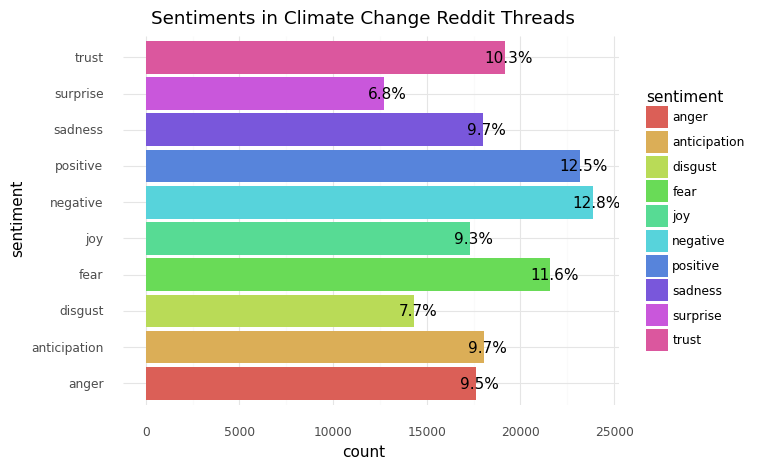

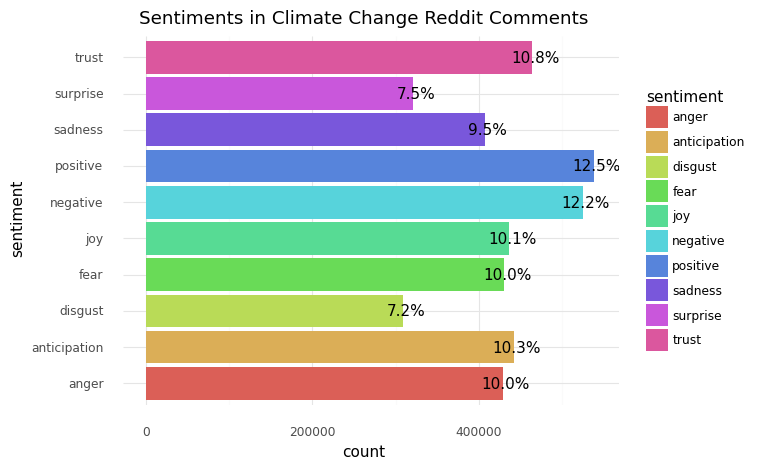

In [5]:
!pip install NRCLex
nltk.download('punkt')
from nrclex import NRCLex

threads_df["sentiment"] = threads_df["word"].apply(lambda x: NRCLex(x).affect_list)
comments_df["sentiment"] = comments_df["word"].apply(lambda x: NRCLex(x).affect_list)
threads_df = threads_df.explode("sentiment").dropna(subset=["sentiment"]).reset_index(drop=True)
comments_df = comments_df.explode("sentiment").dropna(subset=["sentiment"]).reset_index(drop=True)

# plotnine is Python's version of R's ggplot
plot = (
    pn.ggplot(threads_df, pn.aes(x='sentiment')) +
    pn.geom_bar(pn.aes(fill='sentiment')) +
    pn.theme_minimal() +
    pn.coord_flip() +
    pn.geom_text(
     pn.aes(label=pn.after_stat('count / sum(count) * 100')),
     stat='count',
     nudge_y=200,
     format_string='{:.1f}%'
    ) +
    pn.labs(title="Sentiments in Climate Change Reddit Threads")
)
print(plot)

plot = (
    pn.ggplot(comments_df, pn.aes(x='sentiment')) +
    pn.geom_bar(pn.aes(fill='sentiment')) +
    pn.theme_minimal() +
    pn.coord_flip() +
    pn.geom_text(
     pn.aes(label=pn.after_stat('count / sum(count) * 100')),
     stat='count',
     nudge_y=3500,
     format_string='{:.1f}%'
    ) +
    pn.labs(title="Sentiments in Climate Change Reddit Comments")
)
print(plot)

The sentiments across all the threads vs comments are very similar, which makes sense since the thread sort of sets off the overall discussion which then propagates the initial sentiment.

I felt the need to display percentages as I noticed a few discrepanies and wanted to investigate further - Overall, comments are more joyous while threads convey more fear (perhaps to attract more attention to the thread? Eg. Clickbait titles)

3. Now, download the Reddit Climate Change dataset from Kaggle [here](https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset). Read in the data and create the tidy_cc dataset that we created in section 4.3. Then, choose a lexicon (Bing, NRC, or AFINN), and graph the post sentiments according to their scores (similarly to what we did in section 4.3). What do you find?



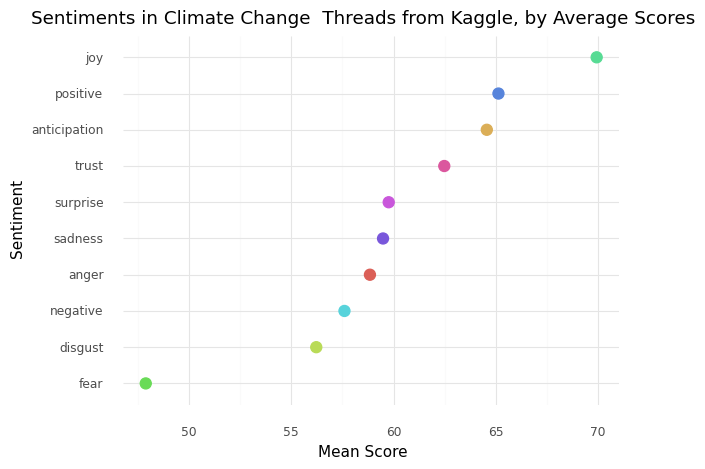

In [ ]:
kaggle_posts_df = unnest_tokens(pd.read_csv(f"drive/My Drive/{FOLDERNAME}/data/kaggle_climate_posts_dataset.csv"), "selftext", ["word", "score"])
kaggle_posts_df["word"] = kaggle_posts_df["word"].astype("str")
# I chose the NRC Lexicon
kaggle_posts_df["sentiment"] = kaggle_posts_df["word"].apply(lambda x: NRCLex(x).affect_list)
kaggle_posts_df = kaggle_posts_df.explode("sentiment").dropna(subset=["sentiment"]).reset_index(drop=True)
sentiment_means_df = kaggle_posts_df.groupby('sentiment')['score'].mean().reset_index().sort_values(by='score', ascending=False)
plot = (
    # reorder: plotnine's internal function reorder inside aes() to change order of values of one variable relative to that of another variable
    pn.ggplot(sentiment_means_df, pn.aes(x='reorder(sentiment, score)', y='score')) +
    pn.geom_point(pn.aes(color='sentiment'), size=4) +
    pn.coord_flip() +
    pn.theme_minimal() +
    pn.theme(legend_position='none') +
    pn.labs(title="Sentiments in Climate Change Threads from Kaggle, by Average Scores",
            x="Sentiment",
            y="Mean Score")
)
print(plot)

Sentiments surrounding climate change in that period were mostly positive. In fact, the sentiments are ordered highest postive to lowest negative.

This ordering makes sense, since posts that bring joy, or are on a positive note will naturally gather upvotes from many, while those that are negative will be perceived poorly and as opposed to a simple downvote, might receive responses like arguments or otherwise.

4. Limit the climate change Reddit posts in some way (for example, you can filter them to posts about Cape Town, or some other place or event, such as the IPCC, or Australian Wildfires). Choose a lexicon (Bing, NRC, or AFINN), and plot the sentiment over time. Can you explain the volatility? BONUS: Plot all three dictionaries. Do you find differences between them?



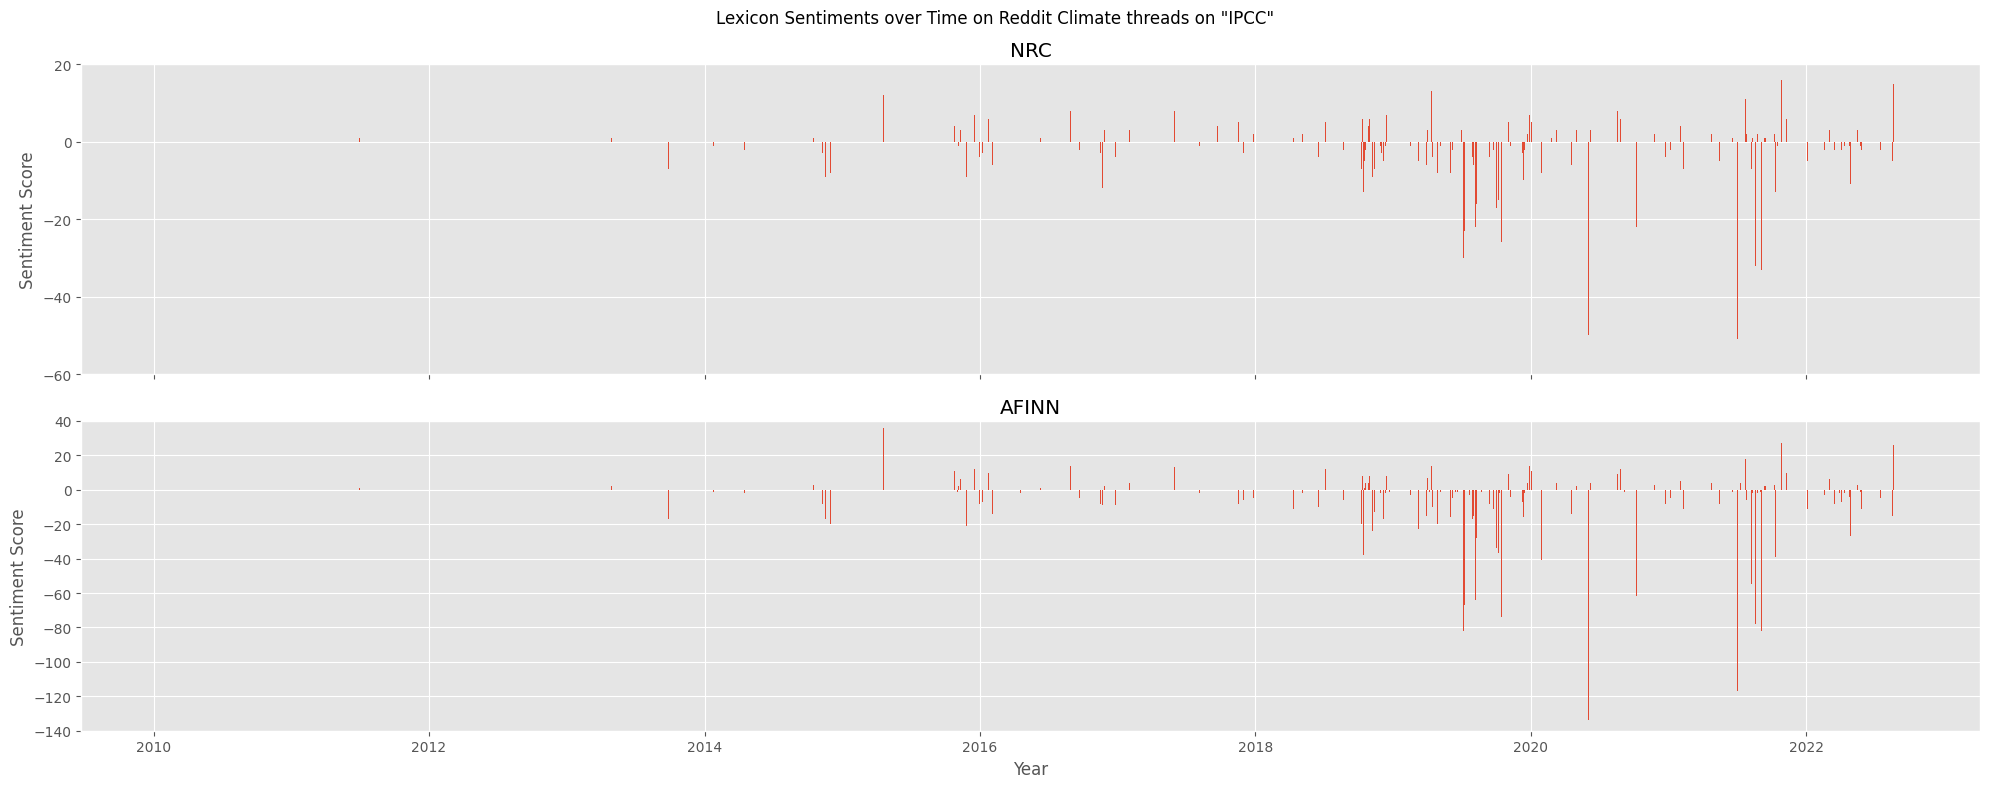

In [ ]:
def get_NRC_sentiment(word):
  result = NRCLex(word).raw_emotion_scores.get("positive", 0) - NRCLex(word).raw_emotion_scores.get("negative", 0)
  return result if result != 0 else None

def get_AFINN_sentiment(word):
  result = afinn.score(word)
  return result if result != 0 else None

df = pd.read_csv(f"drive/My Drive/{FOLDERNAME}/data/kaggle_climate_posts_dataset.csv").dropna(subset=["selftext"])
# Converting epoch time to date only -> daily granularity
df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s").dt.date

# Filtering posts' content to case-insensitive IPCC
filtered_kaggle_posts_df = unnest_tokens(df[df["selftext"].str.contains(r"\bipcc\b", case=False)], "selftext", ["created_utc", "word"])
filtered_kaggle_posts_df["word"] = filtered_kaggle_posts_df["word"].astype("str")

# NRC Lexicon
filtered_kaggle_posts_df["NRC_sentiment"] = filtered_kaggle_posts_df["word"].apply(get_NRC_sentiment)
# AFINN Lexicon
# !pip install afinn
from afinn import Afinn
afinn = Afinn()
filtered_kaggle_posts_df["AFINN_sentiment"] = filtered_kaggle_posts_df["word"].apply(get_AFINN_sentiment)

filtered_kaggle_posts_df.dropna(subset=["NRC_sentiment", "AFINN_sentiment"], inplace=True)
filtered_kaggle_posts_df.set_index("created_utc", inplace=True)
filtered_NRC_sentiment_sums_df = filtered_kaggle_posts_df.groupby('created_utc')['NRC_sentiment'].sum()
filtered_AFINN_sentiment_sums_df = filtered_kaggle_posts_df.groupby('created_utc')['AFINN_sentiment'].sum()

fig, axes = mplt.subplots(2, 1, figsize=(20, 8),  sharex=True)
axes[0].bar(filtered_NRC_sentiment_sums_df.index, filtered_NRC_sentiment_sums_df.values)
axes[0].set_title("NRC")
axes[0].set_ylabel('Sentiment Score')
axes[0].set_yticks(ticks=np.arange(-60, 21, step=20))
axes[0].set_ylim(-60, 20)

axes[1].bar(filtered_AFINN_sentiment_sums_df.index, filtered_AFINN_sentiment_sums_df.values)
axes[1].set_title("AFINN")
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Sentiment Score')
axes[1].set_yticks(ticks=np.arange(-140, 41, step=20))
axes[1].set_ylim(-140, 40)

mplt.suptitle('Lexicon Sentiments over Time on Reddit Climate threads on "IPCC"')
mplt.tight_layout()
mplt.show()

The AFINN lexicon is either a bigger dictionary or calculates polarity of sentiments more extremely, as the AFINN sentiments graph is has higher-highs and lower-lows for the same period.

More recently (2019 onwards), there has been more attention on IPCC, as seen from the magnitude of sentiments. These coincide with IPCC sessions and released reports which always make headlines, such as [those](https://www.ipcc.ch/documentation/ipcc-wg/) in August, September, October in 2019 and February 2020.  However, this sentiment has been mostly extremely negative, as global carbon emissions has been steadily increasing despite the same resolutions to always reduce emissions to zero ASAP. Thus the sentiments could be because the Reddit posters, not able to do much by themselves, are pessimistic that corporations would be even much less likely to.

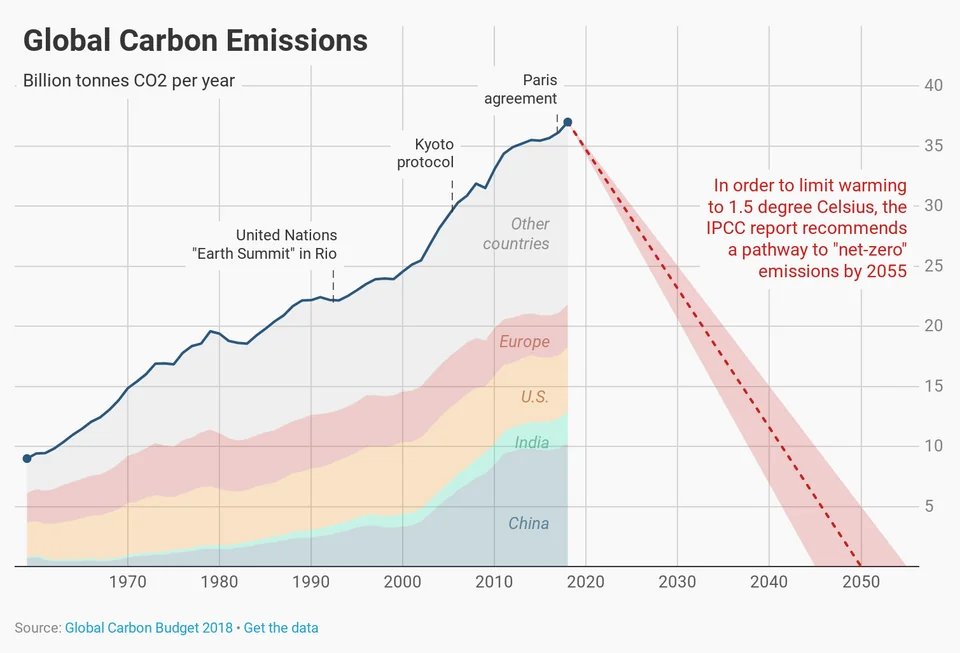

5. Considering disasters such as the Cape Town Water Crisis and Hurricane Katrina, reflect on the implications of people’s sentiments for broader social behaviors. What can we learn by analyzing the sentiments of what people say? Describe another source of text data for which you would like to analyze sentiment related to a disaster, and explain why this would be interesting. Could governments or other organizations benefit from the analysis you describe?

People's sentiments during disaster can reflect how well they are coping and adapting to the situation at that point in time, as well as in the near future. Without reading the news or each of these posts on forums like Reddit, simply plotting the sentiments enable a quick overview of the situation over time.

It could be improving if sentiments gradually become positive, or if it has suddenly taken a downturn, social organizations or governments can allocate more resources to them. However, of course these posts from which the sentiments are derived are all after-the-fact, thus are reactive, but it is still helpful in providing some coverage on the many issues globally.

Twitter can definitely be another source, given that it is also a social media platform like Reddit, and just as established. Furthermore, tweets are often not as nuanced or complete as Reddit posts, are much simpler and shorter and are thus more reflective of the sentiments day-to-day (data is more live/up-to-date).


Since the data is more up-to-date, governments or NGOs or activists would be more responsive and be able to allocate resources/raise awareness more timely.


In [ ]:
# If it contains spaces, use '\ ' to represent each space E.g. 'Summer\ PSet\ 1.ipynb'
FILENAME = "PS4_AndrewYu.ipynb"

%cd drive/My\ Drive
%cd $FOLDERNAME
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!pip install PyPDF2

!jupyter nbconvert --log-level CRITICAL --to pdf $FILENAME

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive/Stanford Summer Session/SOC 128D
[Errno 2] No such file or directory: 'Stanford Summer Session/SOC 128D'
/content/drive/My Drive/Stanford Summer Session/SOC 128D
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base t